In [1]:
from detectors.FEDD import FEDD
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
def insert_value_to_array(array, value):
    '''
    This function adds a value to a given array
    :param: array: the array to add the value
    :param: value: the value to be added
    :return: the array with the added value
    '''

    if(len(array) == 1):
        aux2 = len(array[0])
        aux = [0] * aux2
        aux[len(array[0])-1] = value
        aux[:len(aux)-1] = array[0][1:]
        array[0] = aux
        array[0] = np.asarray(array[0])
        array[0] = np.column_stack(array[0])

        return array

    else:
        aux2 = len(array)
        aux = [0] * aux2
        aux[len(array)-1] = value
        aux[:len(aux)-1] = array[1:]
        array = aux
        array = np.asarray(array)
        array = np.column_stack(array)

        return array

# Reading Data

Training data is the initial reference data.

In [ ]:
data_train = pd.read_csv('./datasets/train/real_53.csv')
data_train = data_train.loc[:, ~data_train.columns.str.contains('^Unnamed')]
data_train

,timestamp,value,is_anomaly
0,1,39.234298,0
1,2,39.191655,0
2,3,39.322198,0
3,4,40.124975,0
4,5,39.485182,0
...,...,...,...
725,726,38.147664,0
726,727,37.778743,0
727,728,37.720224,0
728,729,37.856228,0


Testing data is the data that we compare the reference data with.

In [4]:
data_test = pd.read_csv('./datasets/test/real_53.csv')
data_test = data_test.loc[:, ~data_test.columns.str.contains('^Unnamed')]
data_test

,timestamp,value,is_anomaly
0,731,35.613821,0
1,732,34.576222,0
2,733,34.067086,0
3,734,32.971614,0
4,735,32.782703,0
...,...,...,...
726,1457,21.622908,1
727,1458,23.093519,1
728,1459,22.667180,1
729,1460,23.114132,1


In [5]:
import os

data = pd.DataFrame()
rel_r_e = pd.DataFrame()
r_e_path = "../../../reconstruction_error/LSTM-Autoencoder-2"

for r_e in os.listdir(r_e_path):
    print(r_e)
    df = pd.read_csv(os.path.join(r_e_path, r_e))
    re_df = df / df.sum() * 100
    data = pd.concat([data, df])
    rel_r_e = pd.concat([rel_r_e, re_df])

data = data.reset_index()
data.value = data['0']

selected_instance_0.csv
selected_instance_4.csv
selected_instance_2.csv


/tmp/ipykernel_176819/4146945790.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.value = data['0']


In [6]:
# data_test = data.loc[20000:,:]
data_test = data.loc[189000:189500, :]
data_test.value = data_test['0']

data = data.loc[:10000]
data.value = data['0']

/tmp/ipykernel_176819/3000746804.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data_test.value = data_test['0']
/tmp/ipykernel_176819/3000746804.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.value = data['0']


Extract TS values for testing.

Testing values -> stream

In [13]:
stream = list(data_test.value)

In [14]:
print('TEST DATA LEN',len(stream))

TEST DATA LEN 731


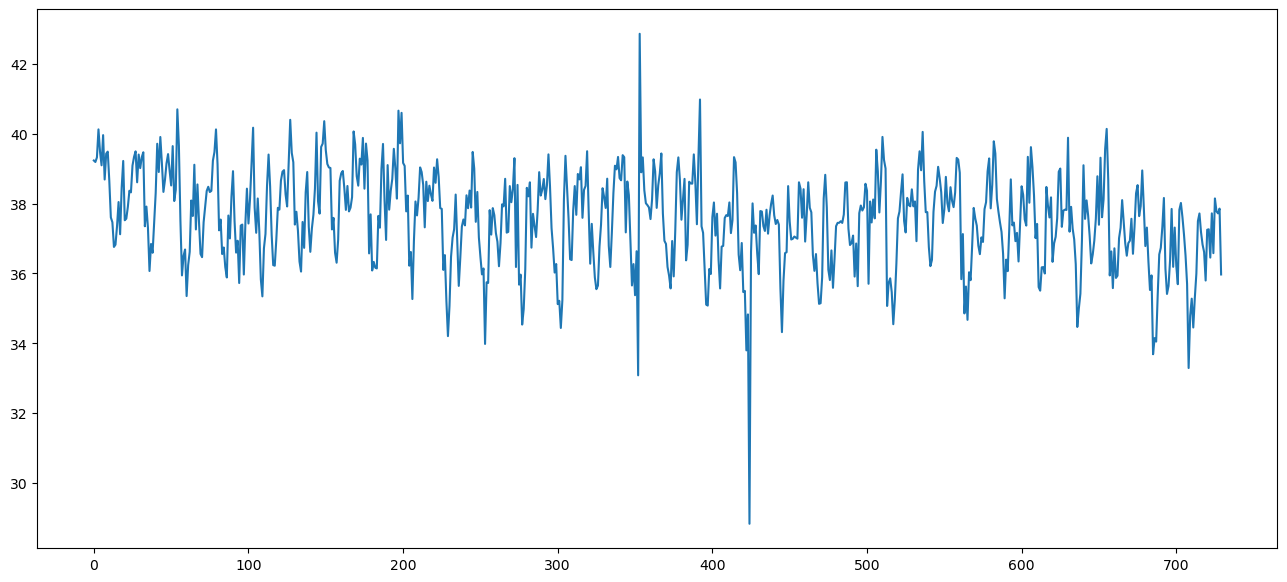

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.plot(data_train.index, data_train.value)
plt.show()

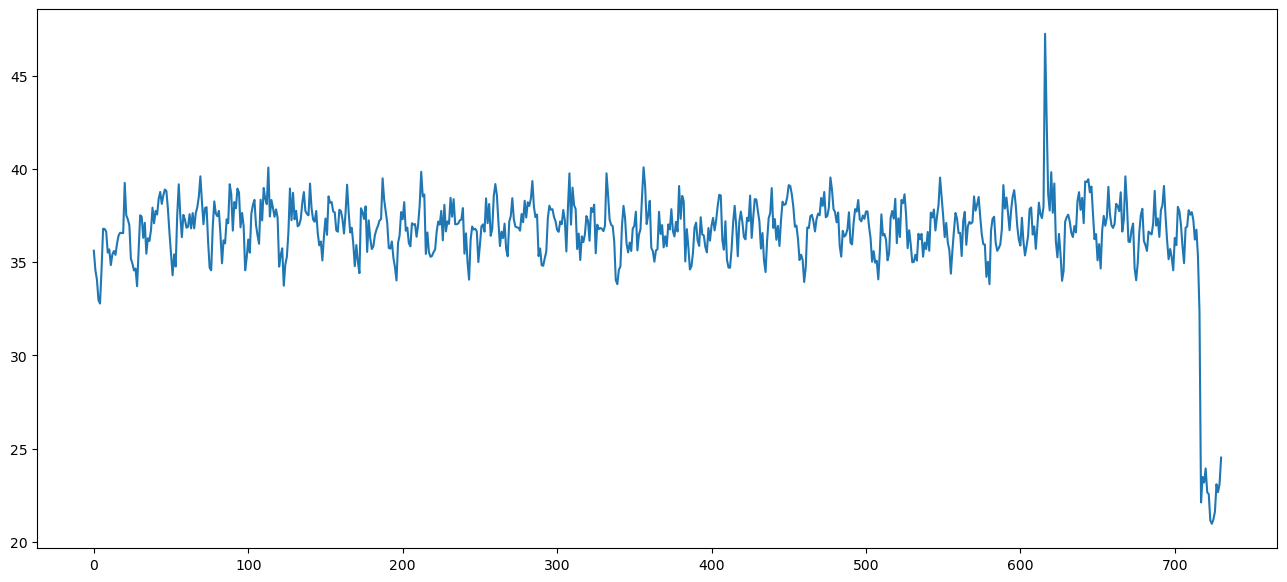

In [7]:
plt.figure(figsize=(16,7))
plt.plot(data_test.index, data_test.value)
plt.show()

In [11]:
# Adjustable parameters
Lambda = 0.2 # higher dive more importance to recent values, vulnerable to noise and outliers
w = 0.25
c = 0.25
n = 300 # timestamps / adjustable??

In [20]:
def Execute(data, grafico = None):
    
    # Detector initialization
    # Initialization is done by extracting two consecutive time series of length = len(reference data)-qtd from the initial reference data and computing the features/distances with FEDD
    qtd = 3 # variable for shifting the reference data
    final = len(data) 
    
    print(final)
    
    fedd = FEDD(Lambda, w, c)
    
    # extracting features reference data time series 1
    feature_vector_0 = fedd.FE(data.value[:final-qtd])
    

    # extracting features reference data time series 2 and computing the distance
    distances_array = []
    for i in range(1, qtd):
        feature_vector = fedd.FE(data.value[i:final-qtd+i])
                
        distance = fedd.compute_distance(feature_vector_0, feature_vector)
        distances_array.append(distance)
    
    # initializing M0
    fedd.storing_agv_dev(feature_vector_0, np.mean(distances_array), np.std(distances_array))
    
    
    drift_occured = False # variable that indicates when drift is detected

    reference_data = list(data.value) # the initial reference data (can be changed)
    
    indexes_drifts = [] # variable for storing the index of drifts
    indexes_alarms = [] # variable for storing the index of warnings
    
    # this method works in an online fashion (it has a sliding window of one sample)
    for i in tqdm(range(1, len(stream))):
        
        
        if(drift_occured == False):
        
            # Sliding Window technique
            # inserting a value from the stream to the initial reference data and forgeting the first value of it
            time_series_window = insert_value_to_array(reference_data, stream[i])
            reference_data = time_series_window
            

            # extracting features from the current time series
            current_feature_vector = fedd.FE(time_series_window[0])


            # computing the distance
            distance = fedd.compute_distance(fedd.initial_feature_vector, current_feature_vector)
            print(distance)
            

            # updating the distance average and standard deviation of ewma
            fedd.update_ewma(distance, i+1)
            
            # monitor changes
            string_fedd = fedd.monitoring()
            
            
            if(string_fedd == fedd.alert):
                if(grafico == True):
                    print("[%d] Warning" % (i))
                indexes_alarms.append(i)

            if(string_fedd == fedd.change):
                if(grafico == True):
                    print("[%d] Change detected" % (i))
                indexes_drifts.append(i)

                drift_occured = True

        else:
            
            # if drift occured before perform initialization after shifting the TS with n to avoid including too much of the old concept
            if(i < indexes_drifts[len(indexes_drifts)-1] + n):
                time_series_window = insert_value_to_array(reference_data, stream[i])
                reference_data = time_series_window
            else:
                
                                
                fedd = FEDD(Lambda, w, c)
                final = len(time_series_window[0])
                qtd = 3
                
                # reinitialization on the new TS
                
                feature_vector_0 = fedd.FE(reference_data[0][:final-qtd])
                
                
                distances_array = []
                
                # computing distances
                for i in range(1, qtd):
                    vetor_caracteristicas = fedd.FE(reference_data[0][i:final-qtd+i])
                    distance = fedd.compute_distance(feature_vector_0, vetor_caracteristicas)
                    distances_array.append(distance)
                
                # updating the distance average and standard deviation of ewma 
                fedd.storing_agv_dev(feature_vector_0, np.mean(distances_array), np.std(distances_array))
                
                drift_occured = False

    return indexes_drifts, indexes_alarms

In [21]:
detected, alarms = Execute(data_train, grafico = True)

730


  7%|▋         | 54/730 [00:00<00:01, 533.15it/s]

3.606694509716846e-08
2.7351393816488212e-08
3.045770891052513e-08
3.731503406267933e-08
8.174687837758654e-08
1.5236615413805055e-07
1.1556003742807519e-07
9.939331191421985e-08
1.2559022355418392e-07
1.1255107446039858e-07
1.0410144202221971e-07
1.142121747177427e-07
1.261963525900356e-07
1.2610154787040528e-07
1.2817949113230753e-07
1.1984414827193035e-07
8.577157306621785e-08
4.933042374588581e-08
2.794418463292203e-08
1.1302320856998449e-07
2.103101286454745e-07
2.0523262278526744e-07
1.9776746296162884e-07
2.6473134384641384e-07
2.689993510163191e-07
2.9872552065324243e-07
2.977815760640823e-07
3.0146296958744045e-07
4.258239575394285e-07
6.031946299112079e-07
5.946700624148704e-07
6.07744309655267e-07
4.5810566529080887e-07
5.986927849033208e-07
6.281514806083521e-07
5.56793297801228e-07
5.409689758373304e-07
6.275978051695219e-07
6.572261113113598e-07
6.375258900792602e-07
5.222906658275406e-07
5.396818500980061e-07
5.312024260462067e-07
4.839970781933545e-07
5.098381691270859e

 15%|█▍        | 109/730 [00:00<00:01, 541.20it/s]

1.0344348854163243e-06
9.390981877688276e-07
1.1875049222842549e-06
1.253415546687009e-06
1.3342985636377591e-06


 28%|██▊       | 207/730 [00:00<00:00, 739.40it/s]

1.336119215822329e-06
1.240928746870651e-06
1.4700486323793172e-06
1.862467126634293e-06
1.87014777297545e-06
1.8975831777012786e-06
1.9130509617548697e-06
1.8715271242752962e-06
1.7946426134063387e-06
2.211156798326286e-06
[120] Change detected


 86%|████████▋ | 631/730 [00:00<00:00, 1262.54it/s]

6.825910503494015e-09
6.8551120335769156e-09
5.290426763338019e-09
5.370755395972537e-09
9.822595374853194e-07
2.4682570242129387e-05
[426] Change detected


100%|██████████| 730/730 [00:00<00:00, 1072.73it/s]

2.6806004083113066e-09
6.696977639109036e-09
7.731599249716226e-09
1.4397186220982405e-08


In [14]:
detected

[1]

In [15]:
alarms

[]

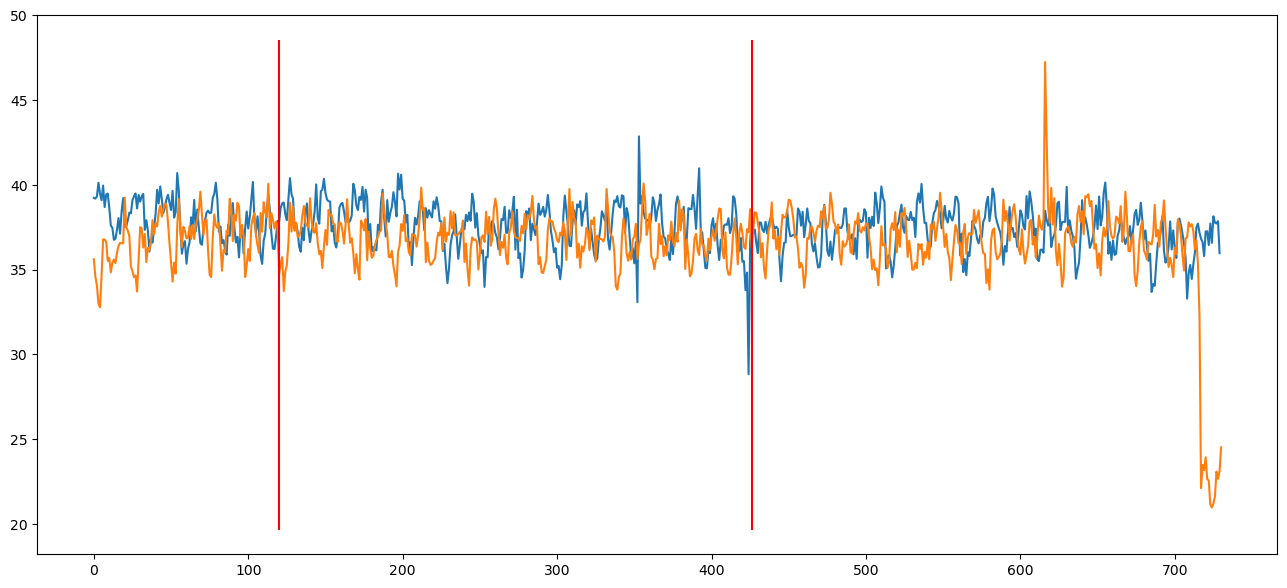

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.plot(data_train.index, data_train.value)
plt.plot(data_test.index, data_test.value)
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(    
    x=detected,
    ymin=ymin,
    ymax=ymax,
    color='red')
plt.show()